In [50]:
import io
import base64
import xml.etree.ElementTree as ET
import requests
from collections import Counter
from Bio import AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline
from flask import Flask, render_template, request
import glob
import matplotlib.pyplot as plt
import requests
import sys
import json
import os
import subprocess
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from collections import OrderedDict
import numpy as np
import threading
import matplotlib
matplotlib.use('Agg')  # or 'Qt5Agg', 'Qt4Agg', etc. depending on your backend


WEBSITE_API = "https://rest.uniprot.org/"
PROTEINS_API = "https://www.ebi.ac.uk/proteins/api"


def fetch_uniprot_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    sequence = "".join(response.text.split("\n")[1:])
    return sequence



def retrieve_protein_features(accession_number):
    url = f"https://www.uniprot.org/uniprot/{accession_number}.xml"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for any HTTP errors

        root = ET.fromstring(response.content)
        namespace = {'uniprot': 'http://uniprot.org/uniprot'}
        protein_features = []

        # Look for the 'feature' tags for transmembrane regions and topological domains
        for feature in root.findall('.//uniprot:feature', namespace):
            feature_type = feature.get('type')
            if feature_type in ['transmembrane region', 'topological domain']:
                begin_element = feature.find('uniprot:location/uniprot:begin', namespace)
                end_element = feature.find('uniprot:location/uniprot:end', namespace)
                
                if begin_element is not None and end_element is not None:
                    begin_position = begin_element.get('position')
                    end_position = end_element.get('position')

                    protein_features.append({
                        "id": accession_number,
                        "type": feature_type,
                        "begin": begin_position,
                        "end": end_position
                    })

        return protein_features

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return []


def read_aa_values_from_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Ensure the DataFrame has the expected columns
    if 'AA' in df.columns and 'Value' in df.columns:
        # Convert DataFrame to a dictionary
        aa_values_dict = pd.Series(df.Value.values, index=df.AA).to_dict()
        return aa_values_dict
    else:
        raise ValueError("CSV must contain 'AA' and 'Value' columns")


def sliding_window_scores(sequence, index_values, window_size=1, normalize_values=False):
    scores = []
    window_size = len(sequence)
    for i in range(len(sequence) - window_size + 1):
        window = sequence[i:i+window_size]
        score = sum(index_values.get(aa, 0) for aa in window) / window_size
        scores.append(score)

    return normalize(scores) if normalize_values else scores

# Function to normalize bulkiness values


def normalize(values):
    min_val = min(values)
    max_val = max(values)
    range_val = max_val - min_val
    return [(val - min_val) / range_val for val in values]


# Function to extract the 2nd row value for each protein ID
def extract_second_row_values(df, feature):
    # Filter the DataFrame for rows where 'type' is 'transmembrane regions'
    transmembrane_df = df[df['type'] == 'transmembrane region']

    # For each 'id', get the first row where 'type' is 'transmembrane regions'
    first_transmembrane_rows = transmembrane_df.groupby('id').first().reset_index()

    # Depending on the feature requested, select and return the appropriate column(s)
    if feature == 'option1':
        return first_transmembrane_rows['volume']
    elif feature == 'option2':
        return first_transmembrane_rows['SA']
    elif feature == 'option3':
        return first_transmembrane_rows['bulkiness']
    elif feature == 'option4':
        return first_transmembrane_rows[ 'hydrophobicity']
    elif feature == 'option5' or feature == 'option6':
        # Assuming 'sequence' is in the DataFrame, return 'id' and 'sequence'
        return first_transmembrane_rows[['sequence']]
    else:
        # For any other option, apply a custom scale based on 'sequence'
        # Ensure 'read_aa_values_from_csv' and 'sliding_window_scores' functions are defined
        first_transmembrane_rows['custom_scale'] = first_transmembrane_rows['sequence'].apply(
            lambda x: sliding_window_scores(
                x, 
                read_aa_values_from_csv(os.path.join(os.getcwd(), 'UCS', 'amino_acid_values.csv')), 
                window_size=1, 
                normalize_values=False
            )
        )
        first_transmembrane_rows['custom_scale'] = first_transmembrane_rows['custom_scale'].apply(lambda x: x[0] if x else None)
        return first_transmembrane_rows['custom_scale']



def is_valid_uniprot_id(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    return response.ok


def run_for_sequence(sequence):
    results = {}
    run_tmbed_sequnce(sequence)
    # Parse the TMbed tool output text into structured data using the function
    parsed_data = []
    file_path = os.path.join(os.getcwd(), 'tmbed', 'sample.pred')
    with open(file_path) as file:
        file_content = file.read()
        entries = file_content.strip().split('>')[1:]
    for entry in entries:
        lines = entry.strip().split('\n')
        if len(lines) < 3:
            print(f"Skipping an entry due to unexpected format: {lines[0]}")
            continue  # Skip this entry
        header = lines[0]
        sequence = lines[1]
        annotation = lines[2]
        if header != 'user_sequence':
            protein_id = header.split('|')[1]
        else:
            protein_id = "user_sequence"

        # Use the previously defined function to parse the annotation
        parsed_data.extend(parse_tmbed_annotation(
            protein_id, sequence, annotation))

    # Create a DataFrame from the parsed data
    result_df = pd.DataFrame(parsed_data)

    result_df['SA'] = result_df['sequence'].apply(lambda x: sliding_window_scores(
        x, surface_area_index_theo, window_size=1, normalize_values=False))
    result_df['volume'] = result_df['sequence'].apply(lambda x: sliding_window_scores(
        x, volume_index, window_size=1, normalize_values=False))
    result_df['bulkiness'] = result_df['sequence'].apply(lambda x: sliding_window_scores(
        x, bulkiness_index, window_size=1, normalize_values=False))
    result_df['hydrophobicity'] = result_df['sequence'].apply(kd_scale_avg)
    result_df['volume'] = result_df['volume'].apply(
        lambda x: x[0] if x else None)
    result_df['SA'] = result_df['SA'].apply(lambda x: x[0] if x else None)
    result_df['bulkiness'] = result_df['bulkiness'].apply(
        lambda x: x[0] if x else None)

    # Reset the index of the result DataFrame if needed
    result_df.reset_index(drop=True, inplace=True)

    results = result_df

    return results


def get_annotations():
    annotaions = list()
    with open('seq_pred_web/region_output.gff3') as f:
        for line in f:
            if not (line.startswith('#')):
                parts = line.split('\t')
                start = int(parts[3])
                end = int(parts[4])
                annotaions.append(start)
                annotaions.append(end)
    return annotaions


def denisty_plot(data1, data2):

    # set the clip parameter
    clip = (-10, None)

    bin_size = 0.1
    max_bins = 9

    # compute the number of bins based on the data range and bin size
    n_bins = min(max_bins, int((data1.max() - data1.min()) / bin_size))
    n_bins_2 = min(max_bins, int((data2.max() - data2.min()) / bin_size))

    # compute the bandwidth
    bw = bin_size / 2

    # compute the bandwidth adjustment factor to get the desired number of bins
    bw_adjust = bw / (data1.max() - data1.min()) * n_bins
    bw_adjust_2 = bw / (data2.max() - data2.min()) * n_bins_2

    # create the plot
    sns.kdeplot(data1, clip=clip, label='List of interest')
    sns.kdeplot(data2, clip=clip, label='Background Set')

    # Perform Kolmogorov-Smirnov (KS) test
    ks_statistic, ks_p_value = stats.ks_2samp(data1, data2)

    # Perform t-test
    t_statistic, t_p_value = stats.ttest_ind(data1, data2, equal_var=False)

    # Perform Wilcoxon rank-sum test (Mann-Whitney U test)
    wilcoxon_statistic, wilcoxon_p_value = stats.mannwhitneyu(
        data1, data2, alternative='two-sided')

    # Annotate the plot with the test results
    plt.text(0.05, 0.95, f'KS Test: p-value = {ks_p_value:.2e}', transform=plt.gca(
    ).transAxes, fontsize=9, verticalalignment='top')
    plt.text(0.05, 0.90, f'T-Test: p-value = {t_p_value:.2e}', transform=plt.gca(
    ).transAxes, fontsize=9, verticalalignment='top')
    plt.text(0.05, 0.85, f'Willcoxin Test: p-value = {wilcoxon_p_value:.2e}',
             transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

    plt.legend()

    # store the plot in a byte stream
    img_bytes = io.BytesIO()
    plt.savefig(img_bytes, format='png')
    img_bytes.seek(0)

    # encode the byte stream as a base64 string
    img_base64 = base64.b64encode(img_bytes.getvalue()).decode('ascii')

    plt.clf()

    return img_base64


def heat_plot(selected_second_row_values):

    df_aac = get_aac(selected_second_row_values[['id', 'sequence']])
    filtered_ids = df_aac[(df_aac['S'] >= 0.5)]['id']
    print(filtered_ids)
    df_heat_plot = df_aac.set_index('id')

    df_heat_plot.index = df_heat_plot.index.map(str)

    # Create the heatmap
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    sns.heatmap(df_heat_plot, annot=False, cmap="viridis", yticklabels=True)
    plt.xticks(rotation=90)  # Rotate x labels if needed
    plt.yticks(rotation=0)  # Ensure y labels are horizontal for readability

    # Aesthetics
    plt.title('Amino Acid Composition Heatmap')
    plt.xlabel('Amino Acids')
    plt.ylabel('IDs')

    img_bytes = io.BytesIO()
    plt.savefig(img_bytes, format='png')
    img_bytes.seek(0)

    # encode the byte stream as a base64 string
    img_base64 = base64.b64encode(img_bytes.getvalue()).decode('ascii')

    # Clear the current figure to free memory
    plt.clf()
    plt.close()
    return img_base64


def get_sequence(entry):
    with open("TMH_sequence_fasta/sequence.fasta", "w") as file:
        r = get_url(f"https://rest.uniprot.org/uniprotkb/{entry}.fasta")
        file.write(r.text)


def read_fasta(fasta_file_name):
    fasta_data = pd.DataFrame(columns=['discrp', 'seq'])
    current_sequence = ""
    last_header = ""
    i = 0
    with open(fasta_file_name) as fasta_file:
        for line in fasta_file:
            line = line.strip()
            if line.startswith(">"):
                if current_sequence == "":
                    last_header = line
                    continue
                else:
                    fasta_data.loc[i] = [last_header.strip('>').split(" ", 1)[
                        0]] + [current_sequence]
                    i += 1
                    current_sequence = ""
                    last_header = line
            else:
                current_sequence += line
        if current_sequence != "":
            fasta_data.loc[i] = [last_header.strip('>').split(" ", 1)[
                0]] + [current_sequence]
            i += 1
        return fasta_data


def get_url(url, **kwargs):
    response = requests.get(url, **kwargs)

    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()

    return response





def kd_scale(seq):
    kd = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
          'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
          'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
          'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

    kd_sum = 0.0
    for aa in seq:
        if aa in kd:
            kd_sum += kd[aa]

    return round(kd_sum, 2)


def kd_scale_avg(seq):
    kd = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
          'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
          'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
          'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

    kd_sum = 0.0
    for aa in seq:
        if aa in kd:
            kd_sum += kd[aa]

    return round((kd_sum/len(seq)), 2)


def ges_scale_avg(seq):
    ges = {'A': 1.6, 'R': -12.3, 'N': -4.8, 'D': -9.2, 'C': 2.0,
           'Q': -4.10, 'E': -8.2, 'G': 1.0, 'H': -3.0, 'I': 3.10,
           'L': 2.8, 'K': -8.8, 'M': 3.4, 'F': 3.7, 'P': -2.0,
           'S': -0.6, 'T': 1.2, 'W': 1.9, 'Y': -0.7, 'V': 2.6}

    ges_sum = 0.0
    for aa in seq:
        if aa in ges:
            ges_sum += ges[aa]

    return round((ges_sum/len(seq)), 2)


def net_charge(seq):
    charge = {'A': 0, 'R': 1, 'N': 0, 'D': -1, 'C': 0,
              'Q': 0, 'E': -1, 'G': 0, 'H': 0, 'I': 0,
              'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0,
              'S': 0, 'T': 0, 'W': 0, 'Y': 0, 'V': 0}

    total_charge = 0.0
    for aa in seq:
        if aa in charge:
            total_charge += charge[aa]

    return round(total_charge, 1)


def zm_polarity(seq):
    zm = {'A': 0, 'R': 53.00, 'N': 3.38, 'D': 49.70, 'C': 1.48,
          'Q': 3.35, 'E': 49.90, 'G': 0, 'H': 51.60, 'I': 0.13,
          'L': 0.13, 'K': 49.50, 'M': 1.43, 'F': 0.35, 'P': 1.58,
          'S': 1.67, 'T': 1.66, 'W': 2.10, 'Y': 1.61, 'V': 0.13}

    zm_sum = 0.0
    for aa in seq:
        if aa in zm:
            zm_sum += zm[aa]

    return round((zm_sum/len(seq)), 2)


def zm_bulkiness(seq):
    zm = {
        'A': 11.50, 'R': 14.28, 'D': 11.68, 'N': 12.82, 'C': 13.46,
        'E': 13.57, 'Q': 14.45, 'G': 3.40, 'H': 13.69, 'L': 21.40,
        'I': 21.40, 'K': 15.71, 'M': 16.25, 'F': 19.80, 'P': 17.43,
        'S': 9.47, 'T': 15.77, 'W': 21.67, 'Y': 18.03, 'V': 21.57}

    zm_sum = 0.0
    for aa in seq:
        if aa in zm:
            zm_sum += zm[aa]

    return round((zm_sum/len(seq)), 2)


def calc_aac(seq_id_pair):
    seq_id, seq = seq_id_pair
    aac_dict = OrderedDict({x: 0 for x in list("ACDEFGHIKLMNPQRSTVWY")})
    for c in seq:
        aac_dict[c] += 1
    aac_values = np.divide(np.array(list(aac_dict.values())), len(seq))
    return [seq_id] + aac_values.tolist()


def get_aac(df):
    aac_data = df.apply(calc_aac, axis=1).tolist()
    aac_df = pd.DataFrame(
        data=aac_data,
        index=df.index,
        columns=['id'] + list("ACDEFGHIKLMNPQRSTVWY")
    )
    return aac_df





def load_tmh_dbs(option_background, option_organism):
    option_background = str(option_background)
    option_organism = str(option_organism)
    if option_organism == 'option1':
        if option_background == 'option1':
            file_path = os.path.join(os.getcwd(), 'backgrounds_tsv', 'PositiveNegative_homo_sapiens.csv')
            df_uniprot = pd.read_csv(file_path)
            df_uniprot['sequence'] = df_uniprot['sequence'].astype(str)
            return df_uniprot
        elif option_background == 'option2':
            file_path = os.path.join(os.getcwd(), 'backgrounds_tsv', 'TMalpha_homo_sapiens.csv')
            df_tmaplha = pd.read_csv(file_path)
            df_tmaplha['sequence'] = df_tmaplha['sequence'].astype(str)
            return df_tmaplha
        elif option_background == 'option3':
            file_path = os.path.join(os.getcwd(), 'backgrounds_tsv', 'TopDB.csv')
            df_topdb = pd.read_csv(file_path)
            df_topdb['sequence'] = df_topdb['sequence'].astype(str)
            return df_topdb
    elif option_organism == 'option2':
        if option_background == 'option1':
            file_path = os.path.join(os.getcwd(), 'backgrounds_tsv', 'PositiveNegative.csv')
            df_uniprot = pd.read_csv(file_path)
            df_uniprot['sequence'] = df_uniprot['sequence'].astype(str)
            return df_uniprot
        elif option_background == 'option2':
            file_path = os.path.join(os.getcwd(), 'backgrounds_tsv', 'TMAlpha.csv')
            df_tmaplha = pd.read_csv(file_path)
            df_tmaplha['sequence'] = df_tmaplha['sequence'].astype(str)
            return df_tmaplha
        elif option_background == 'option3':
            file_path = os.path.join(os.getcwd(), 'backgrounds_tsv', 'TopDB.csv')
            df_topdb = pd.read_csv(file_path)
            df_topdb['sequence'] = df_topdb['sequence'].astype(str)
            return df_topdb

def run_for_tmh_list(uniprot_ids, df_background):

    def extract_sequence(row):
        # Convert 'Begin' and 'End' to integers
        begin_index = int(row['begin']) - 1  # Adjust for 1-based indexing
        end_index = int(row['end'])
        return row['full_sequence'][begin_index:end_index]

    result_df = pd.DataFrame(columns=["id", "begin", "end", "full_sequence", "sequence", "SA", "volume", "bulkiness", "hydrophobicity"])
    
    for uniprot_id in uniprot_ids:
        if uniprot_id in df_background['id'].values:
            rows = df_background[df_background['id'] == uniprot_id]
            result_df = pd.concat([result_df, rows], ignore_index=True)
            print("found in background")
        else:
            protein_features = retrieve_protein_features(uniprot_id)
            if protein_features:
                new_rows = pd.DataFrame(protein_features)
                result_df = pd.concat([result_df, new_rows], ignore_index=True)
                print("extracted from UniProt")

    # Assuming 'df' is your DataFrame and 'uniprot_id' is the column containing UniProt IDs
    unique_ids = result_df['id'].unique()
    # Fetch sequences for unique IDs
    sequences = {uniprot_id: fetch_uniprot_sequence(
        uniprot_id) for uniprot_id in unique_ids}
    # Map sequences onto 'uniprot_id' column in DataFrame
    result_df['full_sequence'] = result_df['id'].map(sequences)
    # Apply the function to each row
    result_df['sequence'] = result_df.apply(extract_sequence, axis=1)
    result_df = result_df.dropna(subset=['sequence'])
    result_df = result_df[result_df['sequence'] != '']
    result_df['SA'] = result_df['sequence'].apply(lambda x: sliding_window_scores(x, surface_area_index_theo, window_size=1, normalize_values=False))
    result_df['volume'] = result_df['sequence'].apply(lambda x: sliding_window_scores( x, volume_index, window_size=1, normalize_values=False))
    result_df['bulkiness'] = result_df['sequence'].apply(lambda x: sliding_window_scores(x, bulkiness_index, window_size=1, normalize_values=False))
    result_df['hydrophobicity'] = result_df['sequence'].apply(kd_scale_avg)
    result_df['volume'] = result_df['volume'].apply(lambda x: x[0] if x else None)
    result_df['SA'] = result_df['SA'].apply(lambda x: x[0] if x else None)
    result_df['bulkiness'] = result_df['bulkiness'].apply(lambda x: x[0] if x else None)

    # Reset the index of the result DataFrame if needed
    result_df.reset_index(drop=True, inplace=True)
    return result_df


# Define a function to parse the annotation into structured data
def parse_tmbed_annotation(protein_id, sequence, annotation):

    # Define the mappings for type and orientation based on the annotation characters
    type_mapping = {'B': 'Transmembrane beta strand', 'H': 'Transmembrane alpha helix',
                    'S': 'Signal peptide', 'i': 'Non-Transmembrane', 'o': 'Non-Transmembrane'}
    orientation_mapping = {'i': 'inside', 'o': 'outside',
                           'B': 'membrane', 'H': 'membrane', 'S': 'membrane'}

    # Initialize variables to keep track of the current annotation type and its start position
    current_type = ''
    current_start = 0
    parsed_data = []

    # Iterate over the annotation characters and sequence simultaneously
    for i, (anno_char, seq_char) in enumerate(zip(annotation, sequence)):
        anno_type = type_mapping.get(anno_char, 'Unknown')
        # Check if the current character is different from the last one, indicating a new region
        if anno_char != current_type:
            # If there was a previous region, save it
            if current_type:
                parsed_data.append({
                    'id': protein_id,
                    'sequence': sequence[current_start:i],
                    'type': type_mapping[current_type],
                    'orientation': orientation_mapping[current_type],
                    'begin': current_start + 1,  # 1-based indexing
                    'end': i,
                    'sequence_length': i - current_start
                })
            # Update the current region's start position and type
            current_start = i
            current_type = anno_char

    # Add the last region if the sequence ended
    if current_type and current_start < len(sequence):
        parsed_data.append({
            'id': protein_id,
            'sequence': sequence[current_start:],
            'type': type_mapping[current_type],
            'orientation': orientation_mapping[current_type],
            'begin': current_start + 1,  # 1-based indexing
            'end': len(sequence),
            'sequence_length': len(sequence) - current_start
        })

    return parsed_data


def run_tmbed_sequnce(sequence):

    file_path = os.path.join(os.getcwd(), 'user_seq', 'user_seq.fasta')
    with open(file_path, "w") as file:
        file.write(">user_sequence\n")  # Default sequence name
        file.write(sequence + "\n")

    working_directory = os.path.join(os.getcwd(), 'tmbed')
    cmd = f"python -m tmbed predict -f {file_path} -p sample.pred --out-format=1"

    try:
        # Run the command with a timeout (e.g., 5 minutes)
        output = subprocess.run(
            cmd, shell=True, capture_output=True, text=True, timeout=300, cwd=working_directory)

        # Print standard output and standard error
        print("Standard Output:\n", output.stdout)
        print("Standard Error:\n", output.stderr)
    except subprocess.TimeoutExpired:
        print("The command took too long to run and was terminated.")
    except subprocess.CalledProcessError as e:
        # This will catch other errors related to the subprocess
        print(f"An error occurred: {e}")


bulkiness_index = {
    'A': 11.500, 'R': 14.280, 'N': 12.820,
    'D': 11.680, 'C': 13.460, 'Q': 14.450,
    'E': 13.570, 'G': 3.400,  'H': 13.690,
    'I': 21.400, 'L': 21.400, 'K': 15.710,
    'M': 16.250, 'F': 19.800, 'P': 17.430,
    'S': 9.470,  'T': 15.770, 'W': 21.670,
    'Y': 18.030, 'V': 21.570
}

volume_index = {
    'A': 88.6,   # Alanine
    'R': 173.4,  # Arginine
    'N': 114.1,  # Asparagine
    'D': 111.1,  # Aspartic acid
    'C': 108.5,  # Cysteine
    'Q': 143.8,  # Glutamine
    'E': 138.4,  # Glutamic Acid
    'G': 60.1,   # Glycine
    'H': 153.2,  # Histidine
    'I': 166.7,  # Isoleucine
    'L': 166.7,  # Leucine
    'K': 168.6,  # Lysine
    'M': 162.9,  # Methionine
    'F': 189.9,  # Phenylalanine
    'P': 112.7,  # Proline
    'S': 89.0,   # Serine
    'T': 116.1,  # Threonine
    'W': 227.8,  # Tryptophan
    'Y': 193.6,  # Tyrosine
    'V': 140.0,  # Valine
    'B': 111.1,  # Asparagine or Aspartic acid (ambiguous)
    'Z': 143.8   # Glutamine or Glutamic acid (ambiguous)
}
# Dictionary for Tien et al. 2013 (Theoretical)
surface_area_index_theo = {
    "A": 129.0,  # Alanine
    "R": 274.0,  # Arginine
    "N": 195.0,  # Asparagine
    "D": 193.0,  # Aspartate
    "C": 167.0,  # Cysteine
    "E": 223.0,  # Glutamate
    "Q": 225.0,  # Glutamine
    "G": 104.0,  # Glycine
    "H": 224.0,  # Histidine
    "I": 197.0,  # Isoleucine
    "L": 201.0,  # Leucine
    "K": 236.0,  # Lysine
    "M": 224.0,  # Methionine
    "F": 240.0,  # Phenylalanine
    "P": 159.0,  # Proline
    "S": 155.0,  # Serine
    "T": 172.0,  # Threonine
    "W": 285.0,  # Tryptophan
    "Y": 263.0,  # Tyrosine
    "V": 174.0,  # Valine
}

# Dictionary for Tien et al. 2013 (Empirical)
surface_area_index_emp = {
    "A": 121.0,  # Alanine
    "R": 265.0,  # Arginine
    "N": 187.0,  # Asparagine
    "D": 187.0,  # Aspartate
    "C": 148.0,  # Cysteine
    "E": 214.0,  # Glutamate
    "Q": 214.0,  # Glutamine
    "G": 97.0,   # Glycine
    "H": 216.0,  # Histidine
    "I": 195.0,  # Isoleucine
    "L": 191.0,  # Leucine
    "K": 230.0,  # Lysine
    "M": 203.0,  # Methionine
    "F": 228.0,  # Phenylalanine
    "P": 154.0,  # Proline
    "S": 143.0,  # Serine
    "T": 163.0,  # Threonine
    "W": 264.0,  # Tryptophan
    "Y": 255.0,  # Tyrosine
    "V": 165.0,  # Valine
}


def extract_tmh_values(df, feature):
    tmh_rows = df[df['type'] == 'transmembrane region']

    # Extract the specified feature from the TMH rows
    if feature == 'option1':
        return tmh_rows['volume']
    elif feature == 'option2':
        return tmh_rows['SA']
    elif feature == 'option3':
        return tmh_rows['bulkiness']
    elif feature == 'option4':
        return tmh_rows[ 'hydrophobicity']
    elif feature == 'option5' or feature == 'option6':
        # Assuming 'sequence' is a column in your DataFrame
        return tmh_rows['sequence']
    else:
        # Apply a custom scale based on 'sequence'
        # This assumes 'sliding_window_scores' and 'read_aa_values_from_csv' are defined elsewhere
        tmh_rows['custom_scale'] = tmh_rows['sequence'].apply(
            lambda x: sliding_window_scores(
                x, 
                read_aa_values_from_csv(os.path.join(os.getcwd(), 'UCS', 'amino_acid_values.csv')), 
                window_size=1, 
                normalize_values=False
            )
        )
        tmh_rows['custom_scale'] = tmh_rows['custom_scale'].apply(lambda x: x[0] if x else None)
        return tmh_rows['custom_scale']

def aac_density_plot(selected, backrground):
   
    df_aac = get_aac(selected[['id', 'sequence']])
    df_aac_2 = get_aac(backrground[['id', 'sequence']])

    file_path = os.path.join('AAC_values', 'AAC_values_helixharbor.tsv')
    df_aac.to_csv(file_path, sep='\t', index=False)

    
    df_aac.drop('id', axis=1, inplace=True)
    df_aac_2.drop('id', axis=1, inplace=True)
    
    clip = (-10, None)
    bin_size = 0.1
    max_bins = 9

    # Creating a 5x4 grid of plots
    fig, axes = plt.subplots(5, 4, figsize=(20, 15))
    fig.tight_layout(pad=5.0)

    # Loop through each amino acid
    for i, amino_acid in enumerate(df_aac.columns):
        ax = axes[i // 4, i % 4]

        # Extracting data for the current amino acid
        data1 = df_aac[amino_acid]
        data2 = df_aac_2[amino_acid]

         
        # Compute the number of bins
        n_bins = min(max_bins, int((data1.max() - data1.min()) / bin_size))
        n_bins_2 = min(max_bins, int((data2.max() - data2.min()) / bin_size))

        # Compute the bandwidth and adjustment factor
        bw = bin_size / 2
        bw_adjust = bw / (data1.max() - data1.min()) * n_bins
        bw_adjust_2 = bw / (data2.max() - data2.min()) * n_bins_2

        # Create the density plot for the current amino acid
        sns.kdeplot(data1, clip=clip, label='List of interest', ax=ax)
        sns.kdeplot(data2, clip=clip, label='Background Set', ax=ax)
        ax.set_title(f'Density Plot for {amino_acid}')

        # Perform statistical tests
        ks_statistic, ks_p_value = stats.ks_2samp(data1, data2)
        t_statistic, t_p_value = stats.ttest_ind(data1, data2, equal_var=False)
        wilcoxon_statistic, wilcoxon_p_value = stats.mannwhitneyu(
            data1, data2, alternative='two-sided')

        # Annotate the plot with test results
        ax.text(0.95, 0.95, f'KS: p={ks_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
                verticalalignment='top', horizontalalignment='right')
        ax.text(0.95, 0.90, f'T-Test: p={t_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
                verticalalignment='top', horizontalalignment='right')
        ax.text(0.95, 0.85, f'Wilcoxon: p={wilcoxon_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
                verticalalignment='top', horizontalalignment='right')
      
    
    plt.legend()
    plt.show()



    img_bytes = io.BytesIO()
    plt.savefig(img_bytes, format='png')
    img_bytes.seek(0)

    # encode the byte stream as a base64 string
    img_base64 = base64.b64encode(img_bytes.getvalue()).decode('ascii')

   

    return img_base64



In [51]:
df_uniprot =  load_tmh_dbs('option1', 'option1')

In [52]:
uniprot_ids = ['B2FKG6','Q1ME61','Q1MIU8','Q7CZU5','A0A060HYY7','A0A090DE86','A0A090GII1','A0A0B4X5K1','A0A0K2VTJ4','A0A0N0JJ42','A0A0Q5XLV8','A0A0Q7A9U5','A0A0Q7W2F7','A0A0Q8BAC8','A0A125QA51', 'A0A178XUF9']

In [18]:
df_test = run_for_tmh_list(uniprot_ids, df_uniprot)

extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt
extracted from UniProt


In [ ]:
df_test[df_test['type'] == 'transmembrane region']

In [53]:
df_uniprot.rename(columns={'Type': 'type'}, inplace=True)


In [59]:
selected_tmh_values = extract_second_row_values(df_test, 'option1')
all_tmh_values = extract_second_row_values(df_uniprot, 'option1')



In [55]:
selected_tmh_values = extract_tmh_values(df_test, 'option1')
all_tmh_values = extract_tmh_values(df_uniprot, 'option1')

In [56]:
all_tmh_values

1        128.947619
3        123.557143
5        133.823810
7        132.490476
9        137.547619
            ...    
40388    139.528571
40391    142.657143
40393    143.709524
40396    154.090000
40399    131.895238
Name: volume, Length: 21107, dtype: float64

In [57]:
%matplotlib inline
def denisty_plot(data1, data2):

    # set the clip parameter
    clip = (-10, None)

    bin_size = 0.1
    max_bins = 9

    # compute the number of bins based on the data range and bin size
    n_bins = min(max_bins, int((data1.max() - data1.min()) / bin_size))
    n_bins_2 = min(max_bins, int((data2.max() - data2.min()) / bin_size))

    # compute the bandwidth
    bw = bin_size / 2

    # compute the bandwidth adjustment factor to get the desired number of bins
    bw_adjust = bw / (data1.max() - data1.min()) * n_bins
    bw_adjust_2 = bw / (data2.max() - data2.min()) * n_bins_2

    # create the plot
    sns.kdeplot(data1, clip=clip, label='List of interest')
    sns.kdeplot(data2, clip=clip, label='Background Set')

    # Perform Kolmogorov-Smirnov (KS) test
    ks_statistic, ks_p_value = stats.ks_2samp(data1, data2)

    # Perform t-test
    t_statistic, t_p_value = stats.ttest_ind(data1, data2, equal_var=False)

    # Perform Wilcoxon rank-sum test (Mann-Whitney U test)
    wilcoxon_statistic, wilcoxon_p_value = stats.mannwhitneyu(
        data1, data2, alternative='two-sided')

    # Annotate the plot with the test results
    plt.text(0.05, 0.95, f'KS Test: p-value = {ks_p_value:.2e}', transform=plt.gca(
    ).transAxes, fontsize=9, verticalalignment='top')
    plt.text(0.05, 0.90, f'T-Test: p-value = {t_p_value:.2e}', transform=plt.gca(
    ).transAxes, fontsize=9, verticalalignment='top')
    plt.text(0.05, 0.85, f'Willcoxin Test: p-value = {wilcoxon_p_value:.2e}',
             transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

    plt.legend()

    plt.show()



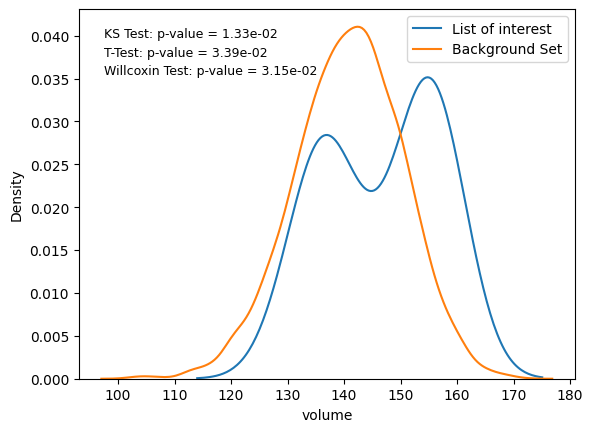

In [60]:
denisty_plot(selected_tmh_values, all_tmh_values)

In [39]:
result_df = pd.DataFrame()
for uniprot_id in uniprot_ids:
        if is_valid_uniprot_id(uniprot_id):
            if uniprot_id in df_uniprot['id'].values:
                rows = df_uniprot[df_uniprot['id'] == uniprot_id]
                result_df = pd.concat([result_df, rows])
                print("found")
            else:
                protein_features = retrieve_protein_features(uniprot_id)
                df_helices = pd.DataFrame(columns=["id", "begin", "end"])
                if protein_features:
                    for helix in protein_features:
                        # print(helix)
                        df_helices = df_helices.append(
                            helix, ignore_index=True)
                print("extracted")            

            result_df = pd.concat([result_df, df_helices])

extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted
extracted


In [40]:
result_df

,id,begin,end


In [20]:
import pandas as pd

# Assuming df_uniprot is your DataFrame and uniprot_ids is your list of IDs
valid_ids = [uid for uid in uniprot_ids if is_valid_uniprot_id(uid)]
filtered_df = df_uniprot[df_uniprot['id'].isin(valid_ids)]

# Prepare a list for data frames to concatenate
dfs_to_concat = [filtered_df]

# Process IDs not found in df_uniprot
for uniprot_id in set(valid_ids) - set(filtered_df['id']):
    protein_features = retrieve_protein_features(uniprot_id)
    if protein_features:
        df_helices = pd.DataFrame(protein_features)
        df_helices['id'] = uniprot_id  # Assuming each row in protein_features has 'begin' and 'end' columns
        dfs_to_concat.append(df_helices)

result_df = pd.concat(dfs_to_concat)


KeyboardInterrupt: 

In [11]:
result_df

,id,sequence,type,orientation,begin,end,sequence_length,charge_per_length,positive_count,negative_count,SA,volume,bulkiness,hydrophobicity,ID,Type,Begin,End
0,P55085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P55085,topological domain,37,71
1,P55085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P55085,transmembrane region,72,101
2,P55085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P55085,topological domain,102,108
3,P55085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P55085,transmembrane region,109,137
4,P55085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P55085,topological domain,138,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,P08172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P08172,topological domain,210,387
11,P08172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P08172,transmembrane region,388,410
12,P08172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P08172,topological domain,411,418
13,P08172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P08172,transmembrane region,419,442


In [9]:
result_df

,id,begin,end,ID,Type,Begin,End
0,NaN,NaN,NaN,P00533,topological domain,25,645
1,NaN,NaN,NaN,P00533,transmembrane region,646,668
2,NaN,NaN,NaN,P00533,topological domain,669,1210
0,NaN,NaN,NaN,P02786,topological domain,1,67
1,NaN,NaN,NaN,P02786,transmembrane region,68,88
...,...,...,...,...,...,...,...
10,NaN,NaN,NaN,P55085,topological domain,270,277
11,NaN,NaN,NaN,P55085,transmembrane region,278,317
12,NaN,NaN,NaN,P55085,topological domain,318,323
13,NaN,NaN,NaN,P55085,transmembrane region,324,347


In [ ]:
df = run_for_tmh_list(uniprot_ids, df_background)

In [163]:
custom_index = read_aa_values_from_csv("/Users/mofty/Downloads/amino_acid_values.csv")


/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/1143861794.py:879: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_helices = df_helices.append(helix, ignore_index=True)
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/1143861794.py:879: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_helices = df_helices.append(helix, ignore_index=True)
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/1143861794.py:879: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_helices = df_helices.append(helix, ignore_index=True)
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/1143861794.py:879: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

In [4]:
def extract_second_row_values(df, feature):

    if feature == 'option1':
        second_rows = df.groupby('id').nth(1)  # nth(1) gets the 2nd row in each group
        return second_rows['volume']
    elif feature == 'option2':
        second_rows = df.groupby('id').nth(1)  # nth(1) gets the 2nd row in each group
        return second_rows['SA']
    elif feature == 'option3':
        second_rows = df.groupby('id').nth(1)  # nth(1) gets the 2nd row in each group
        return second_rows['bulkiness']
    elif feature == 'option4':
        second_rows = df.groupby('id').nth(1)  # nth(1) gets the 2nd row in each group
        second_rows = second_rows.reset_index()
        return second_rows[['id', 'sequence']]

In [5]:
def extract_tmh_values(df, feature):
    # Add a helper column to count rows within each group
    df['row_within_group'] = df.groupby('id').cumcount()

    # Select only the rows where the count is odd (2nd, 4th, 6th, etc.)
    tmh_rows = df[df['row_within_group'] % 2 == 1]

    # Extract the specified feature from the TMH rows
    if feature == 'option1':
        return tmh_rows['volume']
    elif feature == 'option2':
        return tmh_rows['SA']
    elif feature == 'option3':
        return tmh_rows['bulkiness']
    elif feature == 'option4':
        return tmh_rows[['id', 'sequence']]





/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/2681660744.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  bw_adjust = bw / (data1.max() - data1.min()) * n_bins
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/2681660744.py:38: RuntimeWarning: invalid value encountered in scalar multiply
  bw_adjust = bw / (data1.max() - data1.min()) * n_bins
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/2681660744.py:42: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data1, clip=clip, label='List of interest', ax=ax)
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/2681660744.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  bw_adjust = bw / (data1.max() - data1.min()) * n_bins
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/2681660744.py:38: RuntimeWarning: invalid value encountered in scalar mul

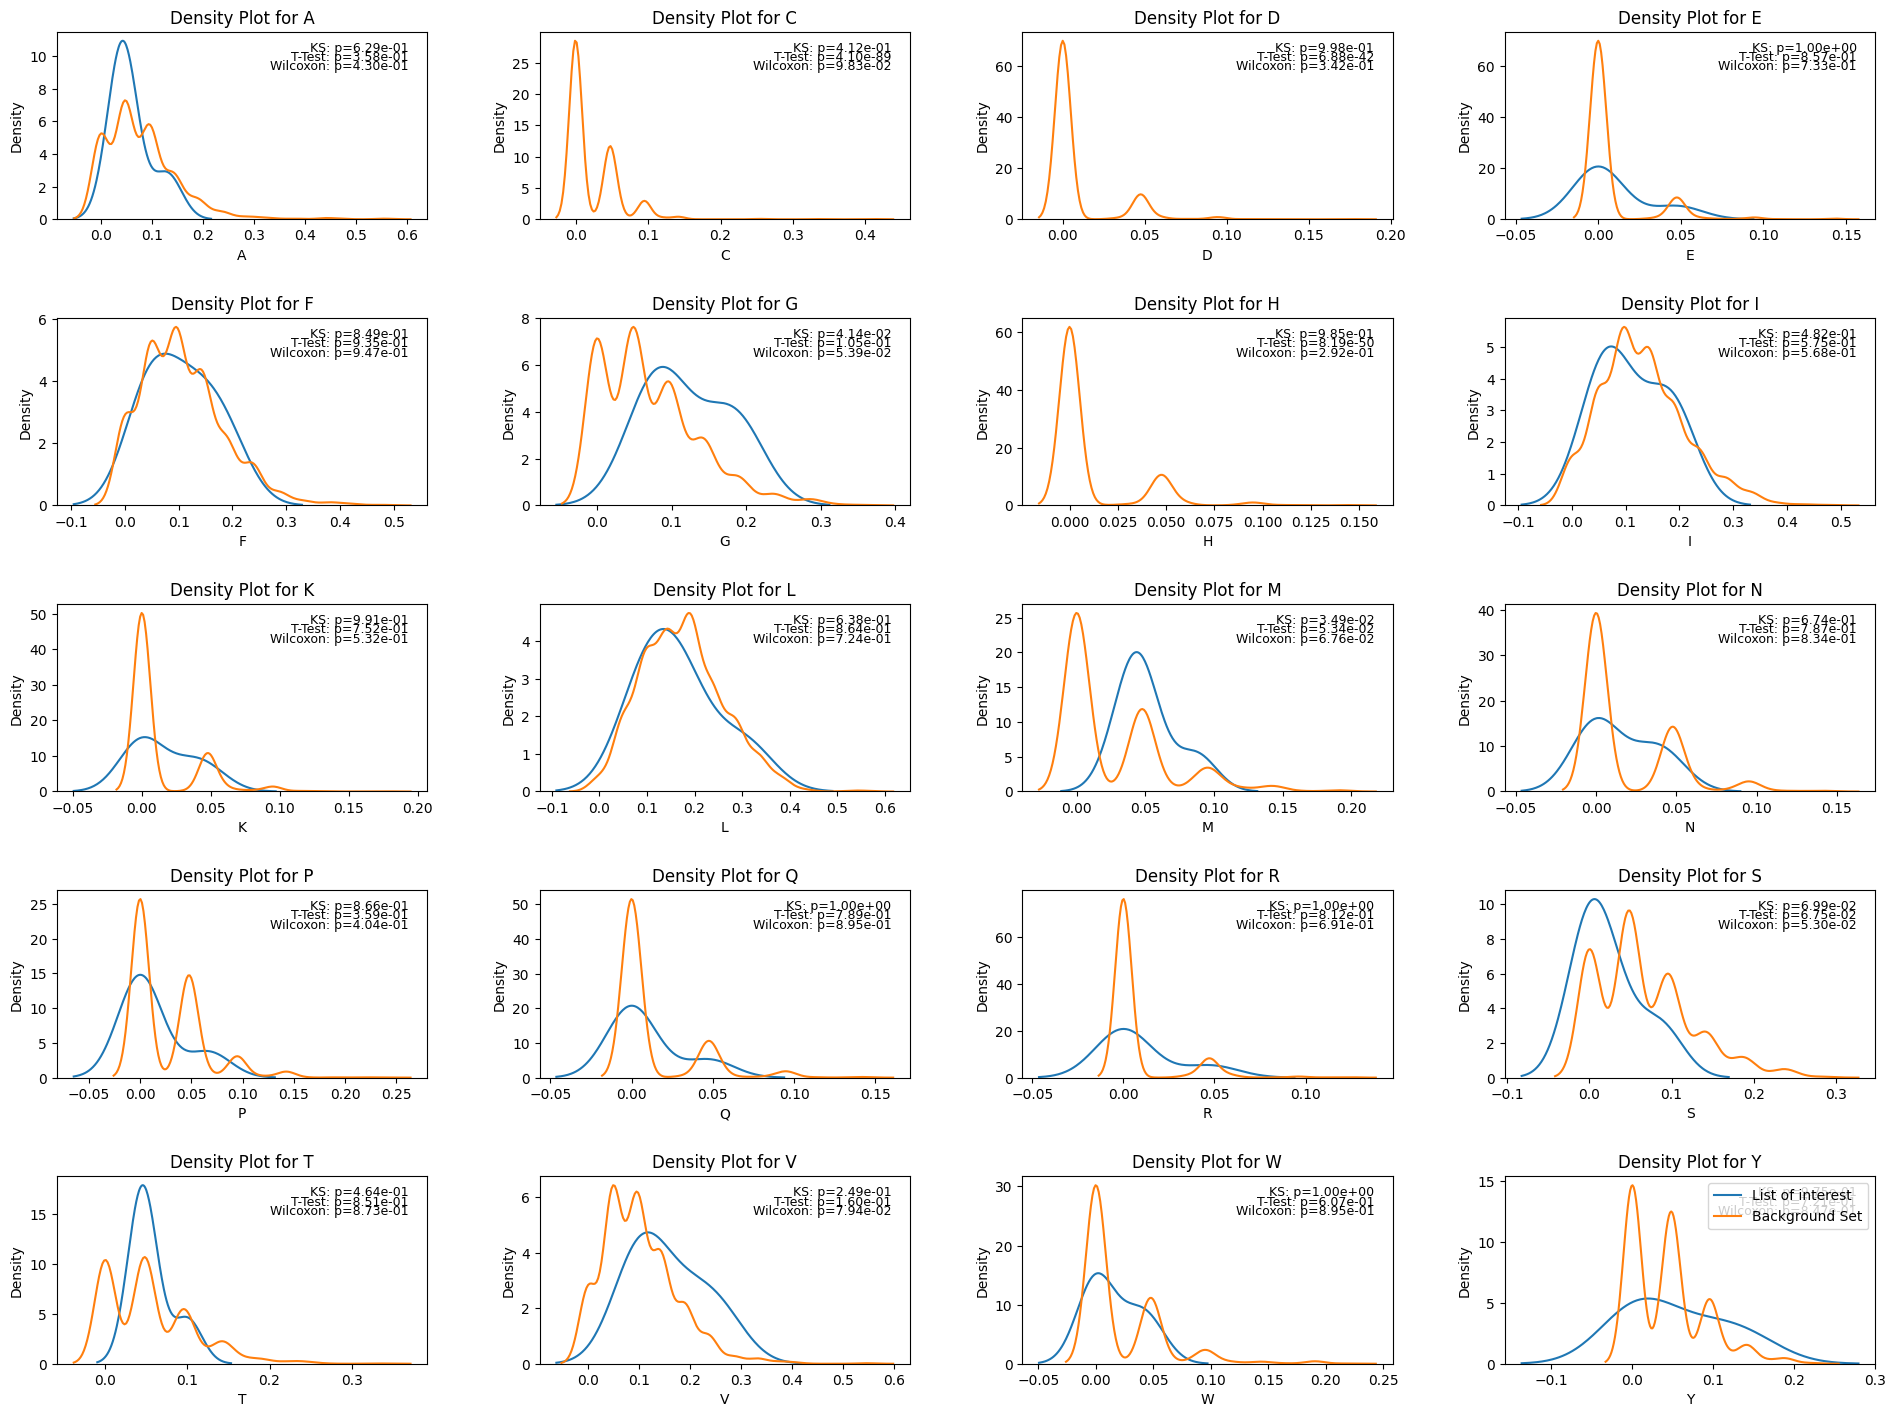

In [26]:
# Extract TMH values for the selected proteins
selected_second_row_values = extract_second_row_values(df, 'option4')
all_second_row_values = extract_second_row_values(df_uniprot, 'option4')

df_aac = get_aac(selected_second_row_values[['id', 'sequence']])
df_aac_2 = get_aac(all_second_row_values[['id', 'sequence']])
df_aac.drop('id', axis=1, inplace=True)
df_aac_2.drop('id', axis=1, inplace=True)

clip = (-10, None)
bin_size = 0.1
max_bins = 9

# Creating a 5x4 grid of plots
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
fig.tight_layout(pad=5.0)

# Loop through each amino acid
for i, amino_acid in enumerate(df_aac.columns):
    ax = axes[i // 4, i % 4]

    # Extracting data for the current amino acid
    data1 = df_aac[amino_acid]
    data2 = df_aac_2[amino_acid]

    # Compute the number of bins
    n_bins = min(max_bins, int((data1.max() - data1.min()) / bin_size))
    n_bins_2 = min(max_bins, int((data2.max() - data2.min()) / bin_size))

    # Compute the bandwidth and adjustment factor
    bw = bin_size / 2
    bw_adjust = bw / (data1.max() - data1.min()) * n_bins
    bw_adjust_2 = bw / (data2.max() - data2.min()) * n_bins_2

    # Create the density plot for the current amino acid
    sns.kdeplot(data1, clip=clip, label='List of interest', ax=ax)
    sns.kdeplot(data2, clip=clip, label='Background Set', ax=ax)
    ax.set_title(f'Density Plot for {amino_acid}')

    # Perform statistical tests
    ks_statistic, ks_p_value = stats.ks_2samp(data1, data2)
    t_statistic, t_p_value = stats.ttest_ind(data1, data2, equal_var=False)
    wilcoxon_statistic, wilcoxon_p_value = stats.mannwhitneyu(
        data1, data2, alternative='two-sided')

    # Annotate the plot with test results
    ax.text(0.95, 0.95, f'KS: p={ks_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.90, f'T-Test: p={t_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.85, f'Wilcoxon: p={wilcoxon_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', horizontalalignment='right')

plt.legend()
plt.show()



In [18]:
# Example usage
df = df.rename(columns={'ID': 'id'})

# Extract TMH values for the selected proteins
selected_second_row_values = extract_second_row_values(df, 'option4')



In [19]:
all_second_row_values = extract_second_row_values(df_uniprot, 'option4')

In [20]:
df_aac = get_aac(selected_second_row_values[['id', 'sequence']])

In [21]:
df_aac_2 = get_aac(all_second_row_values[['id', 'sequence']])

In [22]:
df_aac.drop('id', axis=1, inplace=True)
df_aac_2.drop('id', axis=1, inplace=True)

In [61]:
df_aac

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.130435,0.0,0.0,0.000000,0.043478,0.173913,0.0,0.086957,0.000000,0.304348,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.130435,0.000000,0.000000
1,0.047619,0.0,0.0,0.000000,0.142857,0.190476,0.0,0.190476,0.000000,0.095238,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.095238,0.000000,0.142857
2,0.043478,0.0,0.0,0.000000,0.043478,0.086957,0.0,0.173913,0.000000,0.173913,0.043478,0.043478,0.000000,0.000000,0.000000,0.086957,0.043478,0.260870,0.000000,0.000000
3,0.047619,0.0,0.0,0.047619,0.190476,0.095238,0.0,0.047619,0.047619,0.095238,0.047619,0.000000,0.000000,0.047619,0.047619,0.000000,0.047619,0.095238,0.047619,0.095238
4,0.033333,0.0,0.0,0.000000,0.100000,0.066667,0.0,0.066667,0.033333,0.166667,0.033333,0.033333,0.066667,0.000000,0.000000,0.033333,0.100000,0.200000,0.033333,0.033333


/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/3626345247.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  bw_adjust = bw / (data1.max() - data1.min()) * n_bins
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/3626345247.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  bw_adjust = bw / (data1.max() - data1.min()) * n_bins
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/3626345247.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data1, clip=clip, label='List of interest', ax=ax)
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/3626345247.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  bw_adjust = bw / (data1.max() - data1.min()) * n_bins
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_20353/3626345247.py:35: RuntimeWarning: invalid value encountered in scalar mul

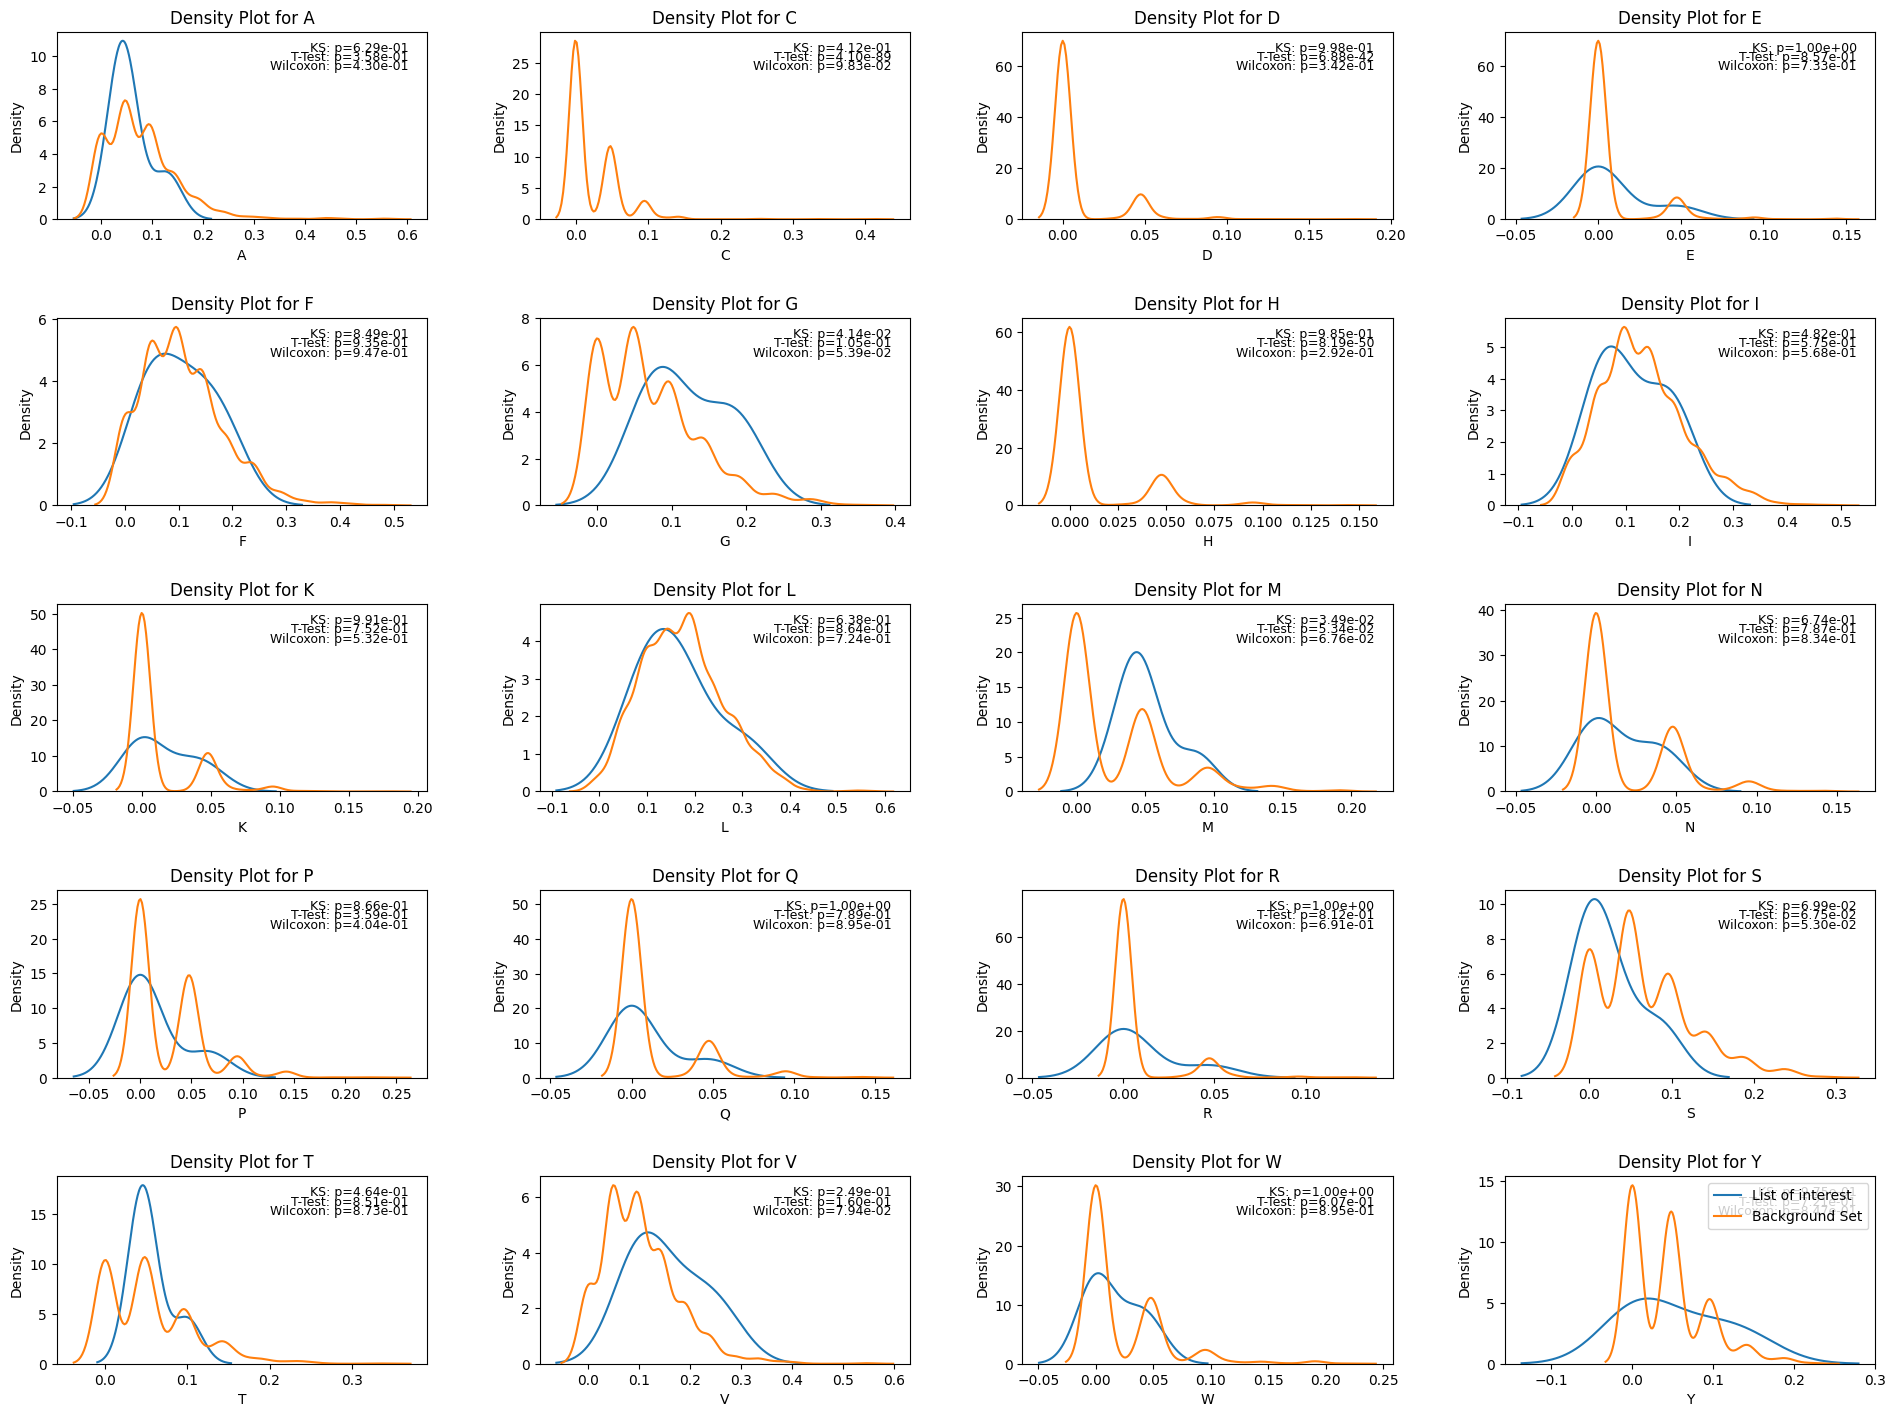

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming df_aac and df_aac_2 are your dataframes
# Calculate the average amino acid composition for each set
avg_composition_set1 = df_aac.mean(axis=0)
avg_composition_set2 = df_aac_2.mean(axis=0)

%matplotlib inline

clip = (-10, None)
bin_size = 0.1
max_bins = 9

# Creating a 5x4 grid of plots
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
fig.tight_layout(pad=5.0)

# Loop through each amino acid
for i, amino_acid in enumerate(df_aac.columns):
    ax = axes[i // 4, i % 4]

    # Extracting data for the current amino acid
    data1 = df_aac[amino_acid]
    data2 = df_aac_2[amino_acid]

    # Compute the number of bins
    n_bins = min(max_bins, int((data1.max() - data1.min()) / bin_size))
    n_bins_2 = min(max_bins, int((data2.max() - data2.min()) / bin_size))

    # Compute the bandwidth and adjustment factor
    bw = bin_size / 2
    bw_adjust = bw / (data1.max() - data1.min()) * n_bins
    bw_adjust_2 = bw / (data2.max() - data2.min()) * n_bins_2

    # Create the density plot for the current amino acid
    sns.kdeplot(data1, clip=clip, label='List of interest', ax=ax)
    sns.kdeplot(data2, clip=clip, label='Background Set', ax=ax)
    ax.set_title(f'Density Plot for {amino_acid}')

    # Perform statistical tests
    ks_statistic, ks_p_value = stats.ks_2samp(data1, data2)
    t_statistic, t_p_value = stats.ttest_ind(data1, data2, equal_var=False)
    wilcoxon_statistic, wilcoxon_p_value = stats.mannwhitneyu(
        data1, data2, alternative='two-sided')

    # Annotate the plot with test results
    ax.text(0.95, 0.95, f'KS: p={ks_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.90, f'T-Test: p={t_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.85, f'Wilcoxon: p={wilcoxon_p_value:.2e}', transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', horizontalalignment='right')

plt.legend()
plt.show()


In [16]:
avg_composition_set1

A    0.060497
C    0.000000
D    0.000000
E    0.009524
F    0.104058
G    0.122650
H    0.000000
I    0.113126
K    0.016190
L    0.167081
M    0.051801
N    0.015362
P    0.013333
Q    0.009524
R    0.009524
S    0.024058
T    0.056439
V    0.156356
W    0.016190
Y    0.054286
dtype: float64

In [17]:
avg_composition_set2

A    0.078911
C    0.022815
D    0.008080
E    0.007687
F    0.106547
G    0.070602
H    0.009716
I    0.130824
K    0.012736
L    0.174074
M    0.027014
N    0.018123
P    0.027142
Q    0.012257
R    0.007103
S    0.066299
T    0.054229
V    0.100472
W    0.021873
Y    0.043497
dtype: float64

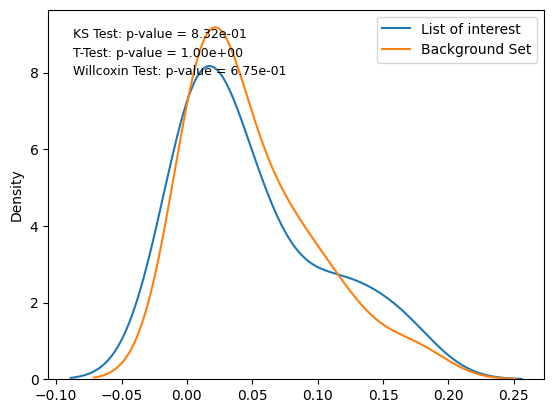

In [11]:
# Drop the 'id' column for plotting


# Calculate the average amino acid composition for each set
avg_composition_set1 = df_aac.mean()
avg_composition_set2 = df_aac_2.mean()

%matplotlib inline 

clip = (-10, None)

bin_size = 0.1
max_bins = 9

# compute the number of bins based on the data range and bin size
n_bins = min(max_bins, int((avg_composition_set1.max() - avg_composition_set1.min()) / bin_size))
n_bins_2 = min(max_bins, int((avg_composition_set2.max() - avg_composition_set2.min()) / bin_size))

# compute the bandwidth
bw = bin_size / 2

# compute the bandwidth adjustment factor to get the desired number of bins
bw_adjust = bw / (avg_composition_set1.max() - avg_composition_set1.min()) * n_bins
bw_adjust_2 = bw / (avg_composition_set2.max() - avg_composition_set2.min()) * n_bins_2

# create the plot
sns.kdeplot(avg_composition_set1, clip=clip, label='List of interest')
sns.kdeplot(avg_composition_set2, clip=clip, label='Background Set')

# Perform Kolmogorov-Smirnov (KS) test
ks_statistic, ks_p_value = stats.ks_2samp(avg_composition_set1, avg_composition_set2)

# Perform t-test
t_statistic, t_p_value = stats.ttest_ind(avg_composition_set1, avg_composition_set2, equal_var=False)

# Perform Wilcoxon rank-sum test (Mann-Whitney U test)
wilcoxon_statistic, wilcoxon_p_value = stats.mannwhitneyu(
    avg_composition_set1, avg_composition_set2, alternative='two-sided')

# Annotate the plot with the test results
plt.text(0.05, 0.95, f'KS Test: p-value = {ks_p_value:.2e}', transform=plt.gca(
).transAxes, fontsize=9, verticalalignment='top')
plt.text(0.05, 0.90, f'T-Test: p-value = {t_p_value:.2e}', transform=plt.gca(
).transAxes, fontsize=9, verticalalignment='top')
plt.text(0.05, 0.85, f'Willcoxin Test: p-value = {wilcoxon_p_value:.2e}',
            transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

plt.legend()

Average Composition Set 1:
 A    0.060497
C    0.000000
D    0.000000
E    0.009524
F    0.104058
G    0.122650
H    0.000000
I    0.113126
K    0.016190
L    0.167081
M    0.051801
N    0.015362
P    0.013333
Q    0.009524
R    0.009524
S    0.024058
T    0.056439
V    0.156356
W    0.016190
Y    0.054286
dtype: float64
Average Composition Set 2:
 A    0.060497
C    0.000000
D    0.000000
E    0.009524
F    0.104058
G    0.122650
H    0.000000
I    0.113126
K    0.016190
L    0.167081
M    0.051801
N    0.015362
P    0.013333
Q    0.009524
R    0.009524
S    0.024058
T    0.056439
V    0.156356
W    0.016190
Y    0.054286
dtype: float64
Set 1 Range: 0.0 to 0.1670807453416149
Set 2 Range: 0.0 to 0.1670807453416149


/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_40834/2598893590.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_40834/2598893590.py:11: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


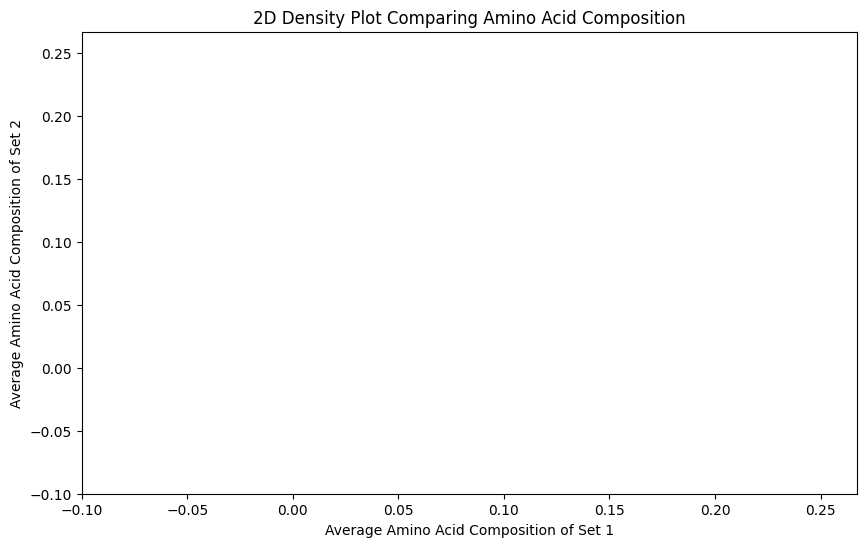

In [57]:
# Print out the average compositions
print("Average Composition Set 1:\n", avg_composition_set1)
print("Average Composition Set 2:\n", avg_composition_set2)

# Check the min and max values
print("Set 1 Range:", avg_composition_set1.min(), "to", avg_composition_set1.max())
print("Set 2 Range:", avg_composition_set2.min(), "to", avg_composition_set2.max())

# Creating the 2D density plot with adjusted bandwidth and plot limits
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=avg_composition_set1, 
    y=avg_composition_set2, 
    cmap="Blues", 
    shade=True, 
    bw_adjust=1  # Adjust this as needed
)
plt.xlim(avg_composition_set1.min() - 0.1, avg_composition_set1.max() + 0.1)  # Adjust the limit range as necessary
plt.ylim(avg_composition_set2.min() - 0.1, avg_composition_set2.max() + 0.1)  # Adjust the limit range as necessary
plt.xlabel('Average Amino Acid Composition of Set 1')
plt.ylabel('Average Amino Acid Composition of Set 2')
plt.title('2D Density Plot Comparing Amino Acid Composition')
plt.show()


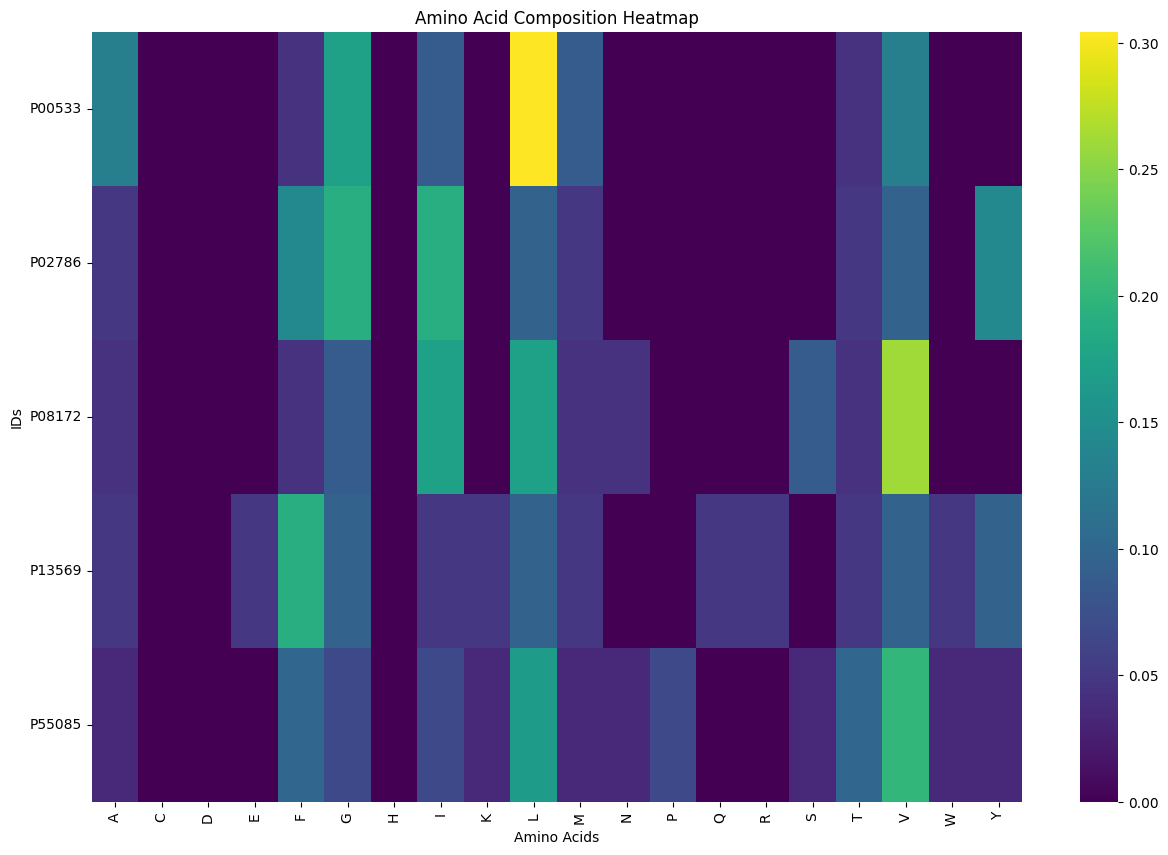

In [178]:
%matplotlib inline
df_heat_plot = df_aac.set_index('id')

# Create the heatmap
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(df_heat_plot, annot=False, cmap="viridis", yticklabels=True)
plt.xticks(rotation=90)  # Rotate x labels if needed
plt.yticks(rotation=0)  # Ensure y labels are horizontal for readability

# Aesthetics
plt.title('Amino Acid Composition Heatmap')
plt.xlabel('Amino Acids')
plt.ylabel('IDs')




# Show the plot
plt.show()

In [99]:
df = df.rename(columns={'ID': 'id'})

In [100]:
selected_second_row_values = extract_second_row_values(df, 'option1')

# Step 3: Extract all 2nd row values from the DataFrame
all_second_row_values = extract_second_row_values(df_uniprot, "option1")



/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_67883/3926789876.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_second_row_values, label="All Proteins", shade=True)


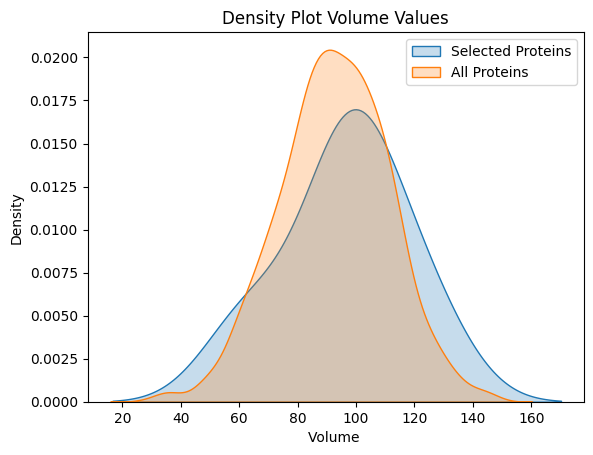

In [102]:

%matplotlib inline
sns.kdeplot(selected_second_row_values, label="Selected Proteins", fill=True)
sns.kdeplot(all_second_row_values, label="All Proteins", shade=True)
plt.xlabel('Volume ')
plt.title('Density Plot Volume Values')
plt.legend()
plt.show()


/var/folders/zh/hjx5tthx15ngn1bxz79cdd6w0000gn/T/ipykernel_67883/813664092.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_tmh_values, label="All Proteins", shade=True)


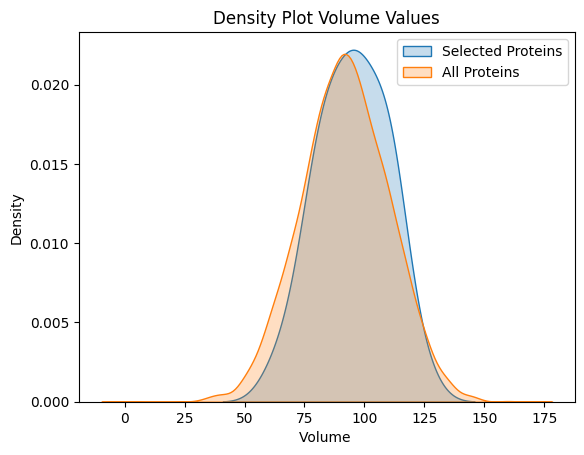

In [105]:

%matplotlib inline
sns.kdeplot(selected_tmh_values, label="Selected Proteins", fill=True)
sns.kdeplot(all_tmh_values, label="All Proteins", shade=True)
plt.xlabel('Volume ')
plt.title('Density Plot Volume Values')
plt.legend()
plt.show()


In [4]:
# Let's write a function that will read the text file and extract the entries.

def read_tmbed_file(file_path):
    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store the parsed data
    ids = []
    sequences = []
    annotations = []

    # Process each line
    for line in lines:
        if line.startswith('>'):
            # Extract the ID from the line
            id_part = line.split(' ')[0]
            protein_id = id_part.split('|')[1]
            ids.append(protein_id)
            # If there was a previous sequence, append it before starting a new one
            if sequences:
                sequences.append(''.join(seq_lines))
                annotations.append(''.join(anno_lines))
            seq_lines = []
            anno_lines = []
        elif line.strip() and not line.startswith('>'):
            # Check if this is a sequence line or an annotation line
            if all(c.isalpha() for c in line.strip()):
                # This is a sequence line
                seq_lines.append(line.strip())
            else:
                # This is an annotation line
                anno_lines.append(line.strip())

    # Add the last sequence and annotation
    if seq_lines:
        sequences.append(''.join(seq_lines))
        annotations.append(''.join(anno_lines))

    return ids, sequences, annotations

# Use the function to read the text file and extract the entries
# The file path needs to be the path where your actual text file is located
file_path = '/Users/mofty/tmbed/sample.pred'  # Replace with your file path
ids, sequences, annotations = read_tmbed_file(file_path)




In [7]:
file_path = '/Users/mofty/tmbed/sample.pred'  # Replace with your file path

In [11]:
with open(file_path, 'r') as file:
    entries = file.readlines()


In [73]:
sequence = 'MTAWILLPVSLSAFSITGIWTVYAMAVMNHHVCPVENWSYNESCPPDPAEQGGPKTCCTLDDVPLISKCGSYPPESCLFSLIGNMGAFMVALICLLRYGQLLEQSRHSWVNTTALITGCTNAAGLLVVGNFQVDHARSLHYVGAGVAFPAGLLFVCLHCALSYQGATAPLDLAVAYLRSVLAVIAFITLVLSGVFFVHESSQLQHGAALCEWVCVIDILIFYGTFSYEFGAVSSDTLVAALQPTPGRACKSSGSSSTSTHLNCAPESIAMI'

In [74]:
run_tmbed_sequnce(sequence)

Standard Output:
 
Standard Error:
 Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.

100%|██████████| 1/1 [00:17<00:00, 17.76s/it]



In [75]:
# Parse the TMbed tool output text into structured data using the function
parsed_data = []
with open("/Users/mofty/HIWI/TMH_project/Flask_Docker_App/tmbed/sample.pred", 'r') as file:
    file_content = file.read()
    entries = file_content.strip().split('>')[1:]    
for entry in entries:
    lines = entry.strip().split('\n')
    if len(lines) < 3:
        print(f"Skipping an entry due to unexpected format: {lines[0]}")
        continue  # Skip this entry
    header = lines[0]
    sequence = lines[1]
    annotation = lines[2]
    if header != 'user_sequence':
        protein_id = header.split('|')[1]
    else:
        protein_id = "user_sequence"

    # Use the previously defined function to parse the annotation
    parsed_data.extend(parse_tmbed_annotation(protein_id, sequence, annotation))

# Create a DataFrame from the parsed data
df_result = pd.DataFrame(parsed_data)

df_result.head()


,id,sequence,type,orientation,begin,end,sequence_length
0,user_sequence,MTA,Non-Transmembrane,inside,1,3,3
1,user_sequence,WILLPVSLSAFSITGIWTVYAM,Transmembrane alpha helix,membrane,4,25,22
2,user_sequence,AVMNHHVCPVENWSYNESCPPDPAEQGGPKTCCTLDDVPLISKCGS...,Non-Transmembrane,outside,26,75,50
3,user_sequence,SCLFSLIGNMGAFMVALICLLRY,Transmembrane alpha helix,membrane,76,98,23
4,user_sequence,GQLLEQSRHS,Non-Transmembrane,inside,99,108,10


In [76]:
df_result['SA'] = df_result['sequence'].apply(lambda x: sliding_window_scores(x, surface_area_index_theo, window_size = 1, normalize_values=False))
df_result['volume'] = df_result['sequence'].apply(lambda x: sliding_window_scores(x, volume_index, window_size=1, normalize_values=False))
df_result['bulkiness'] = df_result['sequence'].apply(lambda x: sliding_window_scores(x, bulkiness_index, window_size=1, normalize_values=False))
df_result['hydrophobicity'] = df_result['sequence'].apply(kd_scale_avg)
df_result['volume'] = df_result['volume'].apply(lambda x: x[0] if x else None)
df_result['SA'] = df_result['SA'].apply(lambda x: x[0] if x else None)
df_result['bulkiness'] = df_result['bulkiness'].apply(lambda x: x[0] if x else None)

In [23]:
df = pd.read_csv("/Users/mofty/HIWI/TMH_project/PositiveNegative.csv")

In [24]:
df = df.dropna(subset=['sequence'])

In [25]:
df['volume'] = df['sequence'].apply(lambda x: sliding_window_scores(x, volume_index, window_size=1, normalize_values=False))
df['volume'] = df['volume'].apply(lambda x: x[0] if x else None)

In [26]:
csv_file_path = '/Users/mofty/HIWI/TMH_project/PositiveNegative.csv'
df.to_csv(csv_file_path, index=False)

In [77]:
results = {}
results = df_result

In [78]:
results

,id,sequence,type,orientation,begin,end,sequence_length,SA,volume,bulkiness,hydrophobicity
0,user_sequence,MTA,Non-Transmembrane,inside,1,3,3,175.000000,122.533333,14.506667,1.00
1,user_sequence,WILLPVSLSAFSITGIWTVYAM,Transmembrane alpha helix,membrane,4,25,22,189.500000,74.031818,16.942727,1.49
2,user_sequence,AVMNHHVCPVENWSYNESCPPDPAEQGGPKTCCTLDDVPLISKCGS...,Non-Transmembrane,outside,26,75,50,183.440000,81.162000,14.697000,-0.56
3,user_sequence,SCLFSLIGNMGAFMVALICLLRY,Transmembrane alpha helix,membrane,76,98,23,188.826087,100.765217,15.837391,1.67
4,user_sequence,GQLLEQSRHS,Non-Transmembrane,inside,99,108,10,198.700000,114.610000,13.558000,-1.26
5,user_sequence,WVNTTALITGCTNAAGLLVVGN,Transmembrane alpha helix,membrane,109,130,22,170.272727,79.677273,15.076364,0.95
6,user_sequence,FQVDHAR,Non-Transmembrane,outside,131,137,7,208.428571,106.985714,15.281429,-0.84
7,user_sequence,SLHYVGAGVAFPAGLLFVCLHCAL,Transmembrane alpha helix,membrane,138,161,24,174.750000,98.362500,15.280833,1.59
8,user_sequence,SYQGATAPLDL,Non-Transmembrane,inside,162,172,11,175.545455,103.354545,14.184545,-0.05
9,user_sequence,AVAYLRSVLAVIAFITLVLSGVFFV,Transmembrane alpha helix,membrane,173,197,25,184.040000,85.364000,17.345600,2.26


In [108]:
first_tmh_sequences = extract_second_row_values(df_result, "option4")

In [109]:
first_tmh_sequences

id
user_sequence    WILLPVSLSAFSITGIWTVYAM
Name: sequence, dtype: object

In [110]:
df

,id,Begin,End,Type,full_sequence,sequence,SA,volume,bulkiness,hydrophobicity,row_within_group
0,P00533,25,645,topological domain,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,190.043478,92.345411,14.646361,-0.37,0
1,P00533,646,668,transmembrane region,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,IATGMVGALLLLLVVALGIGLFM,173.304348,100.213043,16.238261,2.52,1
2,P00533,669,1210,topological domain,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,RRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKK...,194.483395,97.974354,15.268321,-0.43,2
3,P02786,1,67,topological domain,MMDQARSAFSNLFGGEPLSYTRFSLARQVDGDNSHVEMKLAVDEEE...,MMDQARSAFSNLFGGEPLSYTRFSLARQVDGDNSHVEMKLAVDEEE...,190.432836,96.267164,14.077015,-0.70,0
4,P02786,68,88,transmembrane region,MMDQARSAFSNLFGGEPLSYTRFSLARQVDGDNSHVEMKLAVDEEE...,YGTIAVIVFFLIGFMIGYLGY,189.904762,99.614286,16.292857,1.90,1
...,...,...,...,...,...,...,...,...,...,...,...
56,P55085,270,277,topological domain,MRSPSAAWLLGAAILLAASLSCSGTIQGTNRSSKGRSLIGKVDGTS...,RSSAMDEN,193.500000,84.675000,12.380000,-1.61,10
57,P55085,278,317,transmembrane region,MRSPSAAWLLGAAILLAASLSCSGTIQGTNRSSKGRSLIGKVDGTS...,SEKKRKRAIKLIVTVLAMYLICFTPSNLLLVVHYFLIKSQ,202.725000,108.955000,17.226750,0.62,11
58,P55085,318,323,topological domain,MRSPSAAWLLGAAILLAASLSCSGTIQGTNRSSKGRSLIGKVDGTS...,GQSHVY,190.833333,91.783333,13.435000,-0.83,12
59,P55085,324,347,transmembrane region,MRSPSAAWLLGAAILLAASLSCSGTIQGTNRSSKGRSLIGKVDGTS...,ALYIVALCLSTLNSCIDPFVYYFV,192.083333,89.479167,17.223333,1.51,13
